# Test Region
Avoid making long computations again and again with this notebook!

### Structural Similarity Matrix

In [1]:
from data_loading import *
import utils

In [2]:
load_path = "../songs/test"
playlist = load_data(load_path)

In [3]:
print(playlist[0]['song_path'])

../songs/test/ES_Charade - Tape Machines.wav


In [4]:
import numpy as np
import scipy
import sklearn

from madmom.features.beats import RNNBeatProcessor
from madmom.features.beats import DBNBeatTrackingProcessor
from madmom.features.key import CNNKeyRecognitionProcessor
from madmom.features.key import key_prediction_to_label

import librosa

import matplotlib.pyplot as plt

from essentia.standard import FrameGenerator

/home/javig/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [5]:
def beat_detection(song):
    
    proc = DBNBeatTrackingProcessor(fps=100)
    act = RNNBeatProcessor()(song["song_path"])
    beat_times = proc(act)

    # create the array of ones and zeros
    beat_frames = convert_to_frames(beat_times,song)

    # compute the bpm of the song
    bpm = beats_per_minute(beat_times,song)

    return beat_frames, bpm

def convert_to_frames(beat_times, song):

    beat_frames = (beat_times*song["frame_rate"]).astype(int)
    beat_frames_mapped = np.zeros_like(song["audio_array"])
    beat_frames_mapped[beat_frames] = 1
    
    return beat_frames_mapped

def beats_per_minute(beat_times, song):
    
    song_length = len(song["audio_array"])/song["frame_rate"]/60
    beats_count = len(beat_times)
    
    bpm = beats_count/song_length # We could have problems with the first and the last beat
    
    return bpm

In [6]:
def key_detection(song):

    #key = rubberband/madmom (experiment with both)
    
    proc = CNNKeyRecognitionProcessor()
    key_probabilities = proc(song["song_path"])
    key_label = key_prediction_to_label(key_probabilities)

    return key_probabilities, key_label

In [7]:
def structural_segmentation(song):
    
    ssm = structural_similarity_matrix(song)

    print('Shape')
    print(ssm.shape)

    print(ssm)

    fig, ax = plt.subplots()

    c = ax.pcolormesh(ssm, shading='auto', cmap='magma')
    ax.set_title("MFCC of first 10 seconds (Window size = 100ms)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("MFCC Features")
    fig.colorbar(c, ax=ax, format='%+02.0f')

    plt.savefig('ssm.png')

    exit()

    cue_points = detect_cue_points(ssm)

    # create the array of ones and zeros

    pass

In [8]:
def structural_similarity_matrix(song):

    samples_per_beat = int(1.0/(song['estimated_bpm']/(60.0 * song['frame_rate'])))

    win_length = int(0.5 * samples_per_beat)
    hop_length = int(0.25 * samples_per_beat)

    print(win_length, hop_length)

    mspec = librosa.feature.melspectrogram(song['audio_array'], sr=song['frame_rate'], n_mels=128, n_fft=samples_per_beat, window="hann", hop_length=hop_length, win_length=win_length)

    print(mspec.shape)

    log_mspec = librosa.power_to_db(mspec, ref=np.max)

    mfcc = librosa.feature.mfcc(S = log_mspec, sr=song['frame_rate'], n_mfcc=13)

    print(mfcc.shape)

    length = mfcc.shape[1]

    print(length)

    ssm = np.zeros((length,length))

    for i in range(length):
        for j in range(length):
            ssm[i,j] = scipy.spatial.distance.cosine(mfcc[:,i], mfcc[:,j])

    return ssm

In [9]:
def detect_cue_points(ssm):
    pass


In [9]:
song = playlist[0]

In [11]:
beats_frames, bpm = beat_detection(song) 
song['beat_times'] = beats_frames # Array like the samples marking with the beat ocurrs, ones/zeros
song['estimated_bpm'] = bpm # Int

/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [12]:
key_probabilities, key_label = key_detection(song)
song['estimated_key'] = key_label # Probalby string or a int encoding of all the keys
song['key_probabilities'] = key_probabilities

/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [13]:
samples_per_beat = int(1.0/(song['estimated_bpm']/(60.0 * song['frame_rate'])))

win_length = int(0.5 * samples_per_beat)
hop_length = int(0.25 * samples_per_beat)

print(win_length, hop_length)

11965 5982


In [178]:
mspec = librosa.feature.melspectrogram(song['audio_array'], sr=song['frame_rate'], n_mels=128, n_fft=win_length, window="hann", hop_length=hop_length, win_length=win_length)

print(mspec.shape)

log_mspec = librosa.power_to_db(mspec, ref=np.max)

(128, 1601)


In [179]:
mfcc = librosa.feature.mfcc(S = log_mspec, sr=song['frame_rate'], n_mfcc=13)

print(mfcc.shape)

(13, 1601)


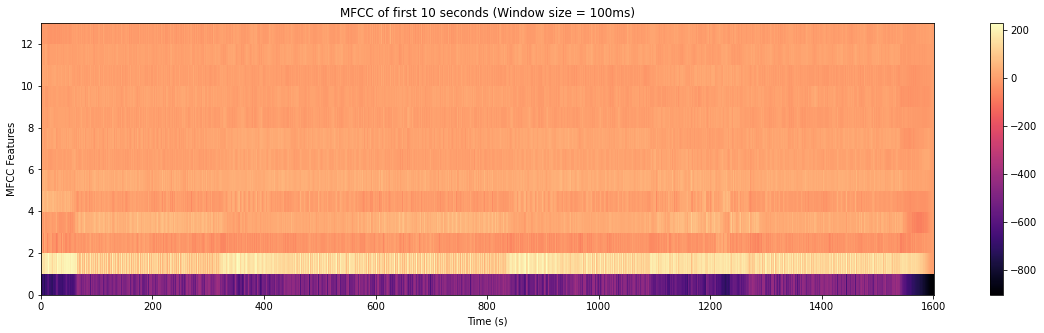

In [180]:
fig, ax = plt.subplots()

c = ax.pcolormesh(mfcc, shading='auto', cmap='magma')
ax.set_title("MFCC of first 10 seconds (Window size = 100ms)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("MFCC Features")
fig.colorbar(c, ax=ax)

plt.show()

#plt.savefig('ssm.png')

In [298]:
ssm = sklearn.metrics.pairwise.cosine_similarity(mfcc.T, mfcc.T)
ssm -= np.average(ssm)
m = np.min(ssm)
M = np.max(ssm)
ssm -= m
ssm /= np.abs(m) + M

In [299]:
print('Shape')
print(ssm.shape)

print(ssm)

Shape
(1601, 1601)
[[1.         0.93795208 0.90744309 ... 0.19814233 0.19369445 0.19369445]
 [0.93795208 1.         0.99381442 ... 0.4336669  0.43000811 0.43000811]
 [0.90744309 0.99381442 1.         ... 0.52481454 0.52112343 0.52112343]
 ...
 [0.19814233 0.4336669  0.52481454 ... 1.         0.99983619 0.99983619]
 [0.19369445 0.43000811 0.52112343 ... 0.99983619 1.         1.        ]
 [0.19369445 0.43000811 0.52112343 ... 0.99983619 1.         1.        ]]


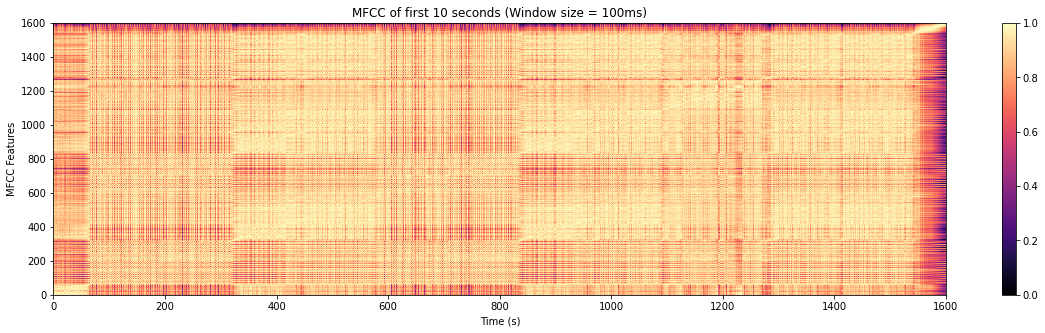

In [300]:
fig, ax = plt.subplots()

c = ax.pcolormesh(ssm, shading='auto', cmap='magma')
ax.set_title("MFCC of first 10 seconds (Window size = 100ms)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("MFCC Features")
fig.colorbar(c, ax=ax)

plt.show()

#plt.savefig('ssm.png')


In [340]:
N=100
M=ssm.shape[0]
result = np.zeros(M)

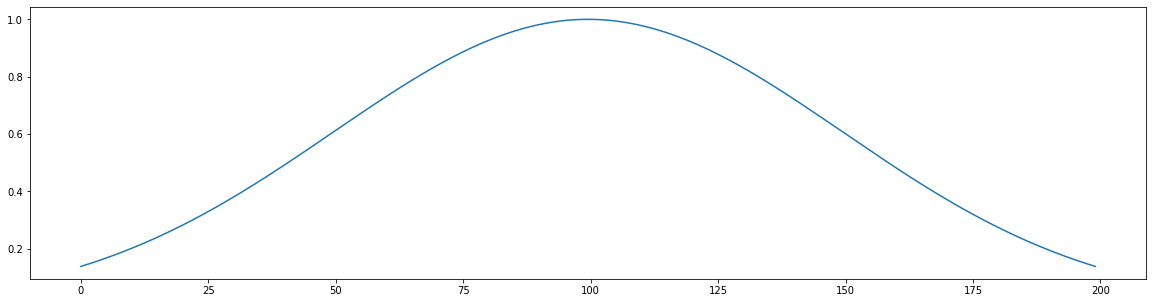

In [341]:
u1 = scipy.signal.gaussian(2*N, std=N/2.0).reshape((-1,1))
u2 = scipy.signal.gaussian(2*N, std=N/2.0).reshape((-1,1))
U = np.dot(u1,np.transpose(u2))
U[:N,N:] *= -1
U[N:,:N] *= -1

plt.plot(u1)
plt.show()

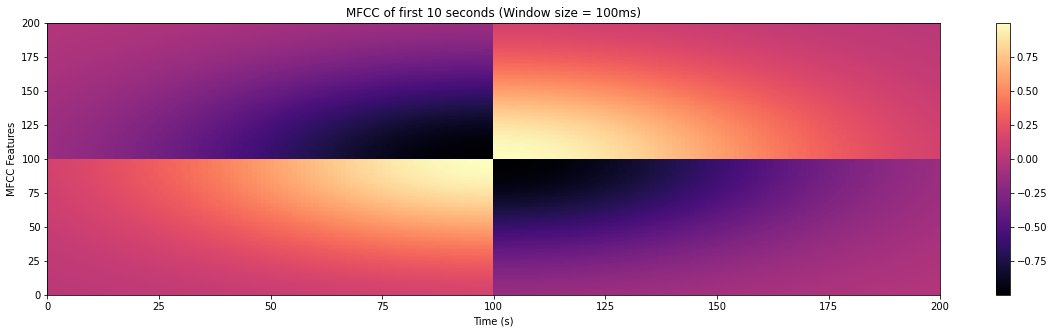

In [342]:
fig, ax = plt.subplots()

c = ax.pcolormesh(U, shading='auto', cmap='magma')
ax.set_title("MFCC of first 10 seconds (Window size = 100ms)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("MFCC Features")
fig.colorbar(c, ax=ax)

plt.show()

In [343]:
matrix_padded = np.pad(ssm, N, mode='edge')
    
for index in range(N, N+M):
    submatrix = matrix_padded[index-N:index+N, index-N:index+N]
    result[index-N] = np.sum(submatrix * U)
    
result /= np.max(result)

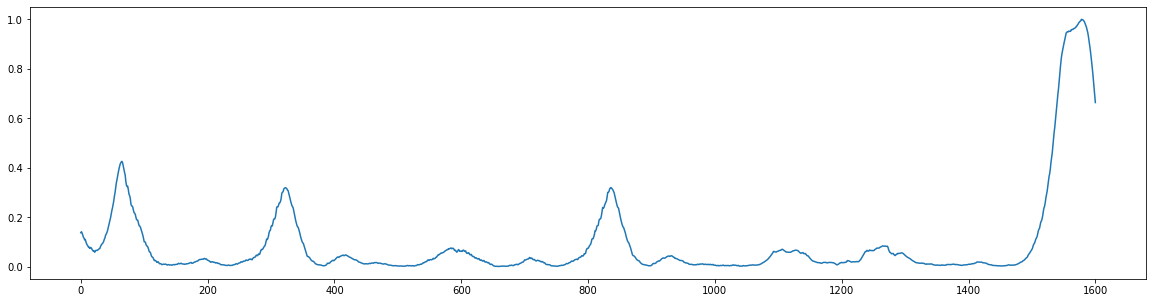

In [344]:
plt.plot(range(len(result)), result)
plt.show()

In [306]:
rms_list = []
for frame in FrameGenerator(playlist[0]['audio_array'], frameSize = win_length, hopSize = hop_length):
    rms_list.append(np.average(frame**2))

In [307]:
print(len(rms_list))

1602


In [308]:
selfsim_rms = sklearn.metrics.pairwise.pairwise_distances(np.array(rms_list).reshape(-1, 1))
selfsim_rms -= np.average(selfsim_rms)
selfsim_rms *= (1.0 / np.max(selfsim_rms))

In [309]:
print(selfsim_rms.shape)

(1602, 1602)


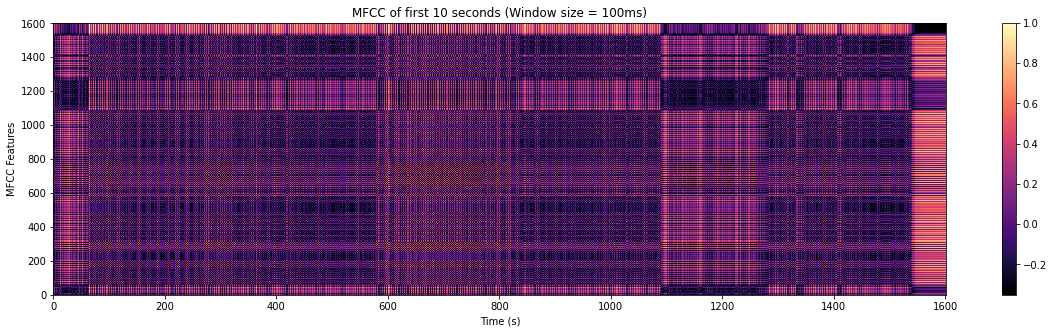

In [310]:
fig, ax = plt.subplots()

c = ax.pcolormesh(selfsim_rms, shading='auto', cmap='magma')
ax.set_title("MFCC of first 10 seconds (Window size = 100ms)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("MFCC Features")
fig.colorbar(c, ax=ax)

plt.show()

#plt.savefig('ssm.png')


In [331]:
N=100
M=selfsim_rms.shape[0]
result_rms = np.zeros(M)

In [334]:
matrix_padded = np.pad(selfsim_rms, N, mode='edge')
    
for index in range(N, N+M):
    submatrix = matrix_padded[index-N:index+N, index-N:index+N]
    result_rms[index-N] = np.sum(submatrix * U)

result_rms /= np.max(result_rms)
result_rms /= np.max(result_rms)

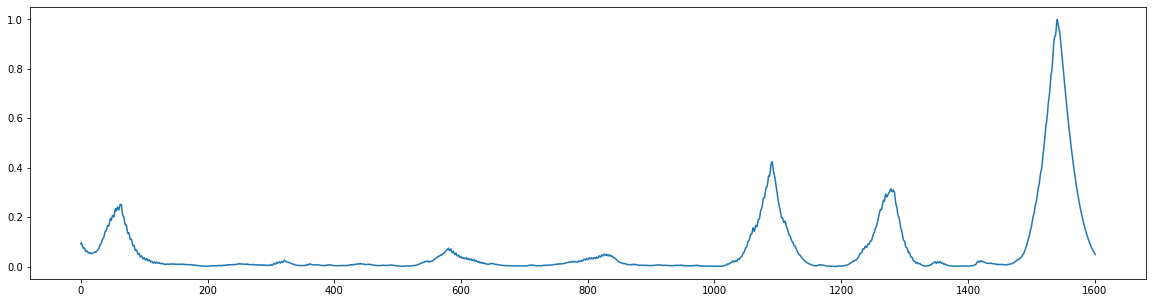

In [335]:
plt.plot(range(len(result_rms)), result_rms)
plt.show()

In [336]:
min_size = min(len(result),len(result_rms))
novelty_product = result[:min_size]*result_rms[:min_size]
novelty_product = np.sqrt(novelty_product)

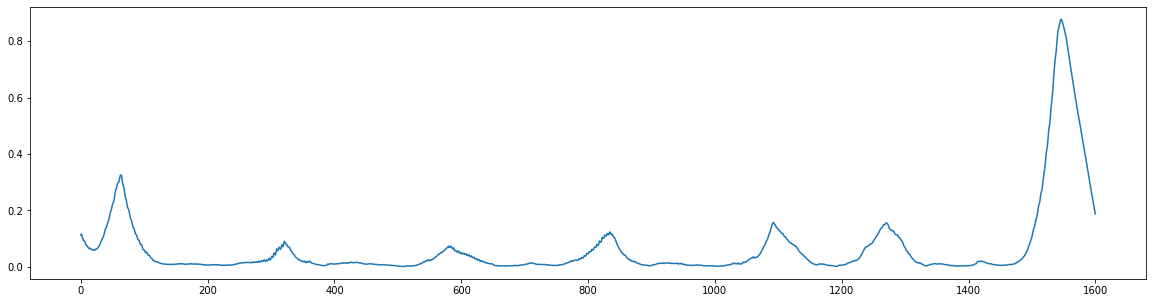

In [337]:
plt.plot(range(len(novelty_product)), novelty_product)
plt.show()

In [353]:
peaks_absmax = np.max(novelty_product)
threshold = peaks_absmax * 0.05

In [363]:
peakDetection = PeakDetection(interpolate=False, maxPeaks=100, orderBy='amplitude', range=len(novelty_product), maxPosition=len(novelty_product), threshold=threshold)
peaks_pos, peaks_ampl = peakDetection(novelty_product.astype('single'))
peaks_ampl = peaks_ampl[np.argsort(peaks_pos)]
peaks_pos = peaks_pos[np.argsort(peaks_pos)]
peaks_pos*= hop_length

29928.695 0.094432175
77814.61 0.06745292
89786.086 0.06608581
113729.04 0.06028716
125700.51 0.06087329
137672.0 0.06286865
383087.28 0.3258763
568645.2 0.0798283
622516.9 0.052918114
1825650.4 0.05000857
1849593.2 0.06439632
1873536.1 0.070006005
1897479.1 0.07896735
1921422.1 0.09108831
1963322.4 0.07146015
3375956.5 0.04559441
3399899.5 0.05169566
3471728.5 0.07416214
3495671.2 0.074089
3519614.2 0.06774674
3537571.8 0.058818046
3567500.2 0.057610787
3591443.2 0.05113554
3615386.2 0.04885203
3633343.5 0.04715289
3663272.2 0.04386416
4776619.5 0.048414193
4800562.5 0.055218574
4824505.5 0.06276839
4854434.5 0.071330406
4872391.5 0.080156006
4896334.5 0.09188127
4926263.0 0.10478799
4944220.0 0.11278652
4968163.0 0.118301235
4992106.0 0.124083884
5016049.0 0.116405316
6536426.5 0.15764731
6745927.5 0.07545355
7583931.0 0.150234
7601888.5 0.1564449
7643788.0 0.1332355
7667731.5 0.12855944
7703646.0 0.11361562
9253952.0 0.8768329



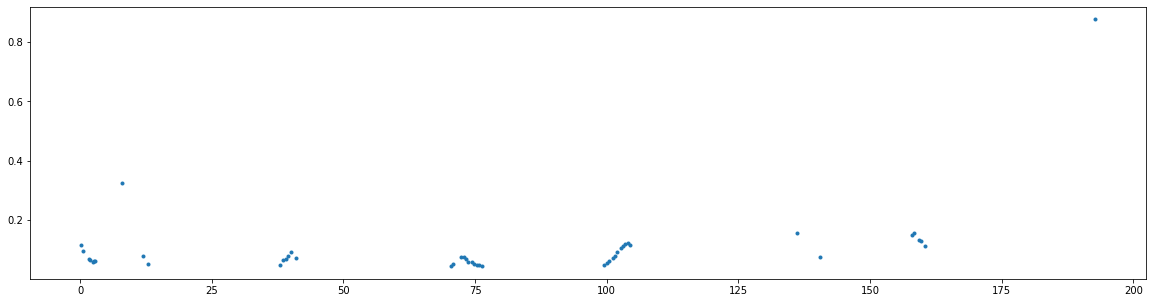

1601 1602
1601


In [365]:
plt.plot(peaks_pos/song['frame_rate'], peaks_ampl, '.')
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

with open('f.txt', 'w') as f:
    f.write(str(list(song['beat_times'])))
    
print(result.size, result_rms.size)
print(novelty_product.size)

## TESTING

In [18]:
from librosa.util.utils import frame
import numpy as np
import scipy
import sklearn

from madmom.features.beats import RNNBeatProcessor
from madmom.features.beats import DBNBeatTrackingProcessor
from madmom.features.key import CNNKeyRecognitionProcessor
from madmom.features.key import key_prediction_to_label

import librosa

from essentia.standard import FrameGenerator, PeakDetection

from data_loading import *
import utils

In [ ]:
load_path = "../songs/test"
playlist = load_data(load_path)

In [21]:
def beat_detection(song):
    
    proc = DBNBeatTrackingProcessor(fps=100)
    act = RNNBeatProcessor()(song["song_path"])
    beat_times = proc(act)

    # create the array of ones and zeros
    beat_frames = convert_to_frames(beat_times,song)

    # compute the bpm of the song
    bpm = beats_per_minute(beat_times,song)

    return beat_frames, bpm

def convert_to_frames(beat_times, song):

    beat_frames = (beat_times*song["frame_rate"]).astype(int)
    beat_frames_mapped = np.zeros_like(song["audio_array"])
    beat_frames_mapped[beat_frames] = 1
    
    return beat_frames_mapped

def beats_per_minute(beat_times, song):
    
    song_length = len(song["audio_array"])/song["frame_rate"]/60
    beats_count = len(beat_times)
    
    bpm = beats_count/song_length # We could have problems with the first and the last beat
    
    return bpm

def key_detection(song):

    #key = rubberband/madmom (experiment with both)
    
    proc = CNNKeyRecognitionProcessor()
    key_probabilities = proc(song["song_path"])
    key_label = key_prediction_to_label(key_probabilities)

    return key_probabilities, key_label

In [22]:

def mfcc_structural_similarity_matrix(song, frame_size, hop_size):

    mspec = librosa.feature.melspectrogram(song['audio_array'], sr=song['frame_rate'], n_mels=128, n_fft=frame_size, window="hann", win_length=frame_size, hop_length=hop_size,)

    log_mspec = librosa.power_to_db(mspec, ref=np.max)

    mfcc = librosa.feature.mfcc(S = log_mspec, sr=song['frame_rate'], n_mfcc=13)

    ssm = sklearn.metrics.pairwise.cosine_similarity(mfcc.T, mfcc.T)
    
    ssm -= np.average(ssm)
    m = np.min(ssm)
    M = np.max(ssm)
    ssm -= m
    ssm /= np.abs(m) + M

    return ssm


def rms_structural_similarity_matrix(song, frame_size, hop_size):

    rms_list = []
    for frame in FrameGenerator(song['audio_array'], frameSize = frame_size, hopSize = hop_size):
        rms_list.append(np.average(frame**2))

    ssm = sklearn.metrics.pairwise.pairwise_distances(np.array(rms_list).reshape(-1, 1))

    ssm -= np.average(ssm)
    m = np.min(ssm)
    M = np.max(ssm)
    ssm -= m
    ssm /= np.abs(m) + M

    return ssm


def get_checkboard_kernel(dim):

    gaussian_x = scipy.signal.gaussian(2*dim, std = dim/2.0).reshape((-1,1))
    gaussian_y = scipy.signal.gaussian(2*dim, std = dim/2.0).reshape((1,-1))

    kernel = np.dot(gaussian_x,gaussian_y)

    kernel[:dim,dim:] *= -1
    kernel[dim:,:dim] *= -1

    return kernel
    

def apply_kernel(ssm, kernel):

    kernel_dim = int(kernel.shape[0]/2)
    ssm_dim = ssm.shape[0]

    novelty = np.zeros(ssm_dim)

    ssm_padded = np.pad(ssm, kernel_dim, mode='edge')

    for index in range(ssm_dim):
        frame = ssm_padded[index:index+2*kernel_dim, index:index+2*kernel_dim]
        novelty[index] = np.sum(frame * kernel)
    
    novelty /= np.max(novelty)
    
    return novelty


def detect_peaks(novelty):

    threshold = np.max(novelty) * 0.05
    
    peakDetection = PeakDetection(interpolate=False, maxPeaks=100, orderBy='amplitude', range=len(novelty), maxPosition=len(novelty), threshold=threshold)
    peaks_pos, peaks_ampl = peakDetection(novelty.astype('single'))
    peaks_ampl = peaks_ampl[np.argsort(peaks_pos)]
    peaks_pos = peaks_pos[np.argsort(peaks_pos)]

    return peaks_pos, peaks_ampl


def find_near_beat(position, beat_times):

    position = int(position)

    i_low = 0
    i_up = 0
    while(position - i_low > 0 and beat_times[position-i_low] == 0):
        i_low += 1
    while(position + i_up < len(beat_times) and beat_times[position+i_up] == 0):
        i_up += 1

    if i_low < i_up:
        return position - i_low
    else:
        return position + i_up


In [11]:
beats_frames, bpm = beat_detection(song) 
song['beat_times'] = beats_frames # Array like the samples marking with the beat ocurrs, ones/zeros
song['estimated_bpm'] = bpm # Int

/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [12]:
key_probabilities, key_label = key_detection(song)
song['estimated_key'] = key_label # Probalby string or a int encoding of all the keys
song['key_probabilities'] = key_probabilities

/home/javig/.local/lib/python3.6/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [13]:
kernel_dim = 32

samples_per_beat = int(1.0/(song['estimated_bpm']/(60.0 * song['frame_rate'])))

frame_size = int(0.5 * samples_per_beat)
hop_size = int(0.25 * samples_per_beat)

In [14]:
mfcc_ssm = mfcc_structural_similarity_matrix(song, frame_size=frame_size, hop_size=hop_size)
rms_ssm = rms_structural_similarity_matrix(song, frame_size=frame_size, hop_size=hop_size)

In [15]:
kernel = get_checkboard_kernel(kernel_dim)
mfcc_novelty = apply_kernel(mfcc_ssm, kernel)
rms_novelty = apply_kernel(rms_ssm, kernel)

In [16]:
size_dif = mfcc_novelty.size - rms_novelty.size
if size_dif > 0:
    rms_novelty = np.pad(rms_novelty, (0, np.abs(size_dif)), mode='edge')
else:
    mfcc_novelty = np.pad(mfcc_novelty, (0, np.abs(size_dif)), mode='edge')

novelty = mfcc_novelty * rms_novelty

In [23]:
peaks_rel_pos, peaks_amp = detect_peaks(novelty)

peaks_abs_pos = peaks_rel_pos * hop_size

peak_times = np.zeros_like(song['audio_array'])

for i in range(len(peaks_abs_pos)):
    beat_peak = find_near_beat(peaks_abs_pos[i], song['beat_times'])
    peak_times[beat_peak] = 1

In [24]:
print(np.where(peak_times==1))

(array([    480,  384480, 1920000, 4992000, 6528480, 7584000, 7608480,
       7680000, 7704000, 9240480]),)


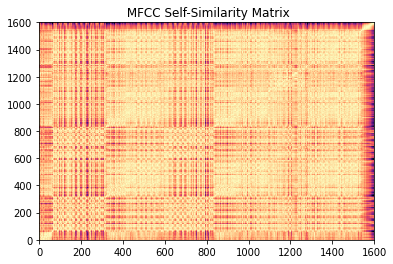

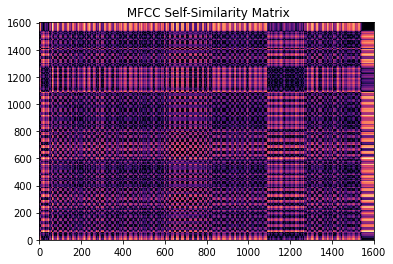

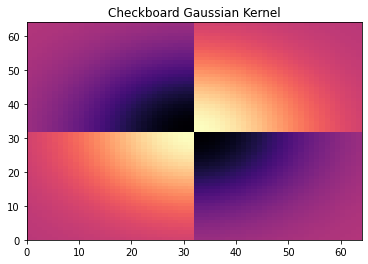

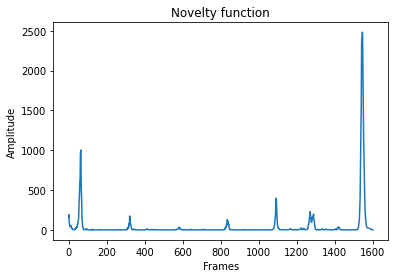

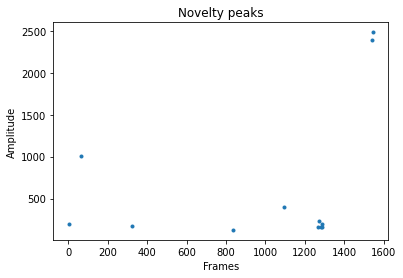

In [28]:
utils.save_cmap(mfcc_ssm, '../figures/mfcc_smm.png', ' MFCC Self-Similarity Matrix')
utils.save_cmap(rms_ssm, '../figures/rms_smm.png', ' MFCC Self-Similarity Matrix')
utils.save_cmap(kernel, '../figures/kernel', 'Checkboard Gaussian Kernel')
utils.save_line(range(len(novelty)), novelty, '../figures/novelty.png', 'Novelty function', 'Frames', 'Amplitude')
utils.save_line(peaks_rel_pos, peaks_amp, '../figures/peaks.png', 'Novelty peaks', 'Frames', 'Amplitude', '.')